# Week 04 seminar: Finetuning.

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.1.2+cu121', torchvision.__version__='0.16.2+cpu', device=device(type='cuda'), torch.get_num_threads()=4


## TorchVision

[Torchvision](https://pytorch.org/vision/main/index.html) - part of PyTorch library with convenient tools and data for deep learning in visual domain.
- contains a number of popular vision [datasets](https://pytorch.org/vision/stable/datasets.html)
- preprocessing [tools](https://pytorch.org/vision/stable/transforms.html)
- and most importantly, [pre-trained models](https://pytorch.org/vision/main/models.html).

# Datasets: Imagenet

![imagenet_tiles](https://i.imgur.com/n4QIrzF.jpeg)

Today we're going to use and fine-tune CNN based on weights pre-trained on ImageNet.

What is Imagenet?
- large size image classification dataset.
    - ImageNet-1K contains 1,281,167 training images, 50,000 validation images and 100,000 test images.
    - Full original dataset (ImageNet-21k) contains 14,197,122 images divided into 21,841 classes
    - Resolution varies, average resolution: 469x387 pixels
- built pre-2010 by [Fei-Fei Li](https://en.wikipedia.org/wiki/Fei-Fei_Li) at Princeton
- made very popular by ImageNet Large Scale Visual Recognition Challenge (ILSVRC). See AlexNet moment: [chart](https://www.researchgate.net/figure/ImageNet-Competition-Results-50_fig1_329975404), [wiki](https://en.wikipedia.org/wiki/AlexNet), [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
-  still relevant; [accuracy history 2013 to date](https://paperswithcode.com/sota/image-classification-on-imagenet)
- More about Imagenet: http://image-net.org/,  https://en.wikipedia.org/wiki/ImageNet

In [2]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


# Pretrained models: Resnet


Torchvision models classification models with benchmarks may be viewed [here.](https://pytorch.org/vision/main/models.html#classification)

For this seminar we're going to use Pytorch implementation of popular Resnet model.

In [3]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [46]:
# view the model structure. Familiar layers are combined into 4 blocks
# note the last LINEAR layer named 'fc' that converts embeddings of size 512 into logits for 1000 Imagenet classes
from torchinfo import summary
summary(model,
        input_size=(64, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 224, 224]    [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
├─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [64, 64, 56, 56]     [64, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [64, 64, 56, 56]     [64, 64, 56, 56]     36,864               True
│    │    └─BatchN

### testing the pretrained model 1
test output dimensions with dummy inputs<br>
note that model inputs have to be 4D: (batch_size, color_channes, height, width)<br>
output is a 2D tensor of logits (batch_size, number_of_classes)

In [5]:
dummy_x = torch.randn(5, 3, 224, 224, device=device)  # dummy batch of 5 'images' sized 224x224 with 3 channels, created on GPU
result = model(dummy_x)
assert result.shape == (5, 1000)   # output is a 2D tensor of logits (batch_size, number_of_classes)

### testing the pretrained model 2. Predict class probabilities.

(224, 224)


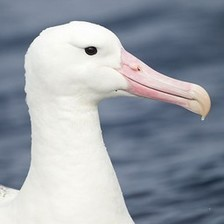

In [6]:
# loading image with PIL library
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source
print(img.size)
img

In [7]:
# converting PIL image to torch.Tensor - detailed process
img_torch = torch.tensor(np.array(img), device=device)  # convert PIL image to np.array, then to torch.Tensor,
img_torch = img_torch.permute(2,0,1)  # reorder channels to move color to the front position, to match pytorch conventions
img_torch = img_torch / img_torch.max()  # scale to 0..1

img_torch.shape, img_torch.device, img_torch.min().item(), img_torch.max().item()  # verify shape, device and range

(torch.Size([3, 224, 224]),
 device(type='cuda', index=0),
 0.007843137718737125,
 1.0)

In [8]:
# converting PIL image to torch.Tensor - easy process
# PIL image to torch.Tensor can be converted with torchvision.transforms, equivalent to the above code (more details below)
img_torch = transforms.ToTensor()(img)
img_torch.shape, img_torch.max(), img_torch.min()

(torch.Size([3, 224, 224]), tensor(1.), tensor(0.0078))

In [9]:
# Predicting image class with pretrained model


def predict_img(img, model, top_n=5):
    if isinstance(img, str):
        Image.open(requests.get(url, stream=True).raw).convert('RGB')  # for loading images from url

    img_torch = transforms.ToTensor()(img)  # to torch.Tensor, reorder color channels, s|cale to 0..1
    img_torch = transforms.Resize((224, 224))(img_torch)      # another useful transform to resize images
    img_torch = img_torch.unsqueeze(0)                        # add batch dimension (remember that model needs 4D input)
    img_torch = img_torch.to(device)                          # moving the tensor to device (presumably cuda, in initialized above)
    prediction = model(img_torch)                             # obtain prediction logits from the model
    probs = torch.nn.functional.softmax(prediction, dim=-1)   # convert logits into probabilities
    probs = probs.cpu().data.numpy()                          # convert CUDA tensor to numpy array

    top_ix = probs.ravel().argsort()[-1: -top_n - 1: -1]      # get indices of most probable classes
    print (f'top-{top_n} classes:')                           # look up class label
    for l in top_ix:
        print (f"{probs.ravel()[l]:>6.2%}  {imagenet_labels[l].split(',')[0]}")


predict_img(img, model)

top-5 classes:
98.70%  albatross
 0.46%  spoonbill
 0.39%  American_egret
 0.19%  goose
 0.12%  crane


### testing the pretrained model 3: Images from unknown classes

Play with imahes from these and other (yours) URLS. Note how object outsize of imagenet classes confuse the net. Low probabilities in top classes are indications of model's low confidence.

(750, 500)


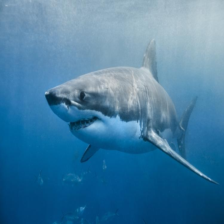

top-5 classes:
58.31%  great_white_shark
40.35%  tiger_shark
 0.67%  sturgeon
 0.35%  hammerhead
 0.16%  gar


d:\Practical_DL\.venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
url= 'https://www.fisheries.noaa.gov/s3/styles/full_width/s3/2021-11/Great%20White%203.jpg'                    # modern version

# <TRY ANY OTHER IMAGES YOU LIKE>

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
print(web_img.size)
display(transforms.Resize((224, 224))(web_img))
predict_img(web_img, model)

## More Torchvision tools: Transforms and transform pipelines¶

You already used `transforms.ToTensor` and `transforms.Resize` above. There are many more at [Torchvision](https://pytorch.org/vision/stable/transforms.html). For easier application they are typically combined into pipelines. See examples below.

For more advanced tranforms (faster and compatible with tasks requiring mask or reference points), check out [Albumentations library](https://albumentations.ai/).

In [11]:
from torchvision import transforms

# Typical transform pipeline for test loop
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize imaged according to ImageNet standards
])

img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alt link
img_torch = transform_pipeline(img)

print(type(img_torch), img_torch.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


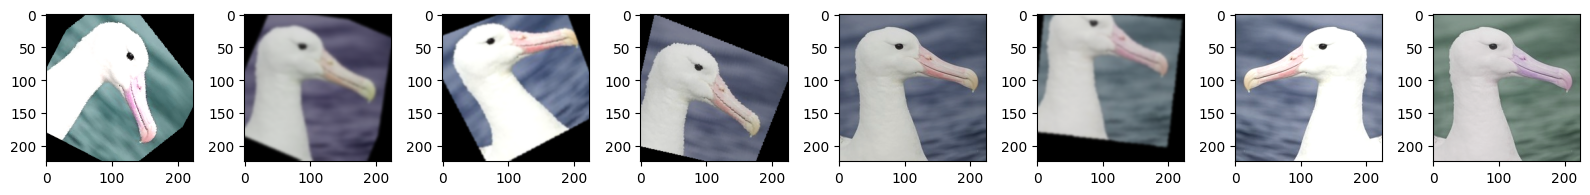

In [12]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source

# Demo of augmentations for train pipeline

transform_pipeline_2 = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),  # not always applicable
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Optional: normalizes imaged according to ImageNet standards
])

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_2 = transform_pipeline_2(img)
    ax.imshow(img_2.permute(1, 2, 0))
plt.tight_layout()

# Classifying with CNN model's latent features
Pretrained image classification models learn extract image features that are useful in classification tasks. We need to get those features from outputs of the model's penultimate level and pass them to classifier.
While this is not exactly a proper finetuning, this method is quick, rather robust and allows to classify unknown classes using quite small training sets (tens / hundreds of images).

### How to get features
features = activations before the very last Linear layer of the model (named `fc` in Resnet - check the model structure above.

During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [13]:
class Identity(torch.nn.Module):
    """replacement for the last model layer to deliver the unaltered inputs of the last layer"""

    def forward(self, x):
        return x

# it is practically same as torch.nn.Identity() - check https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Identity

In [14]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = Identity()    # redefine the last layer to be Identity|
embedding_model = embedding_model.to(device)  # move the result to CUDA

In [15]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg') # alt link
img_torch = transforms.ToTensor()(img).unsqueeze(0).to(device)
out = embedding_model(img_torch).cpu().data.numpy()
assert out.shape == (1, 512), "your output for single image should have shape (1, 512)"

# Starter problem: cat-dog classification
Your next task is to use a pre-trained model to distinguish between cats and dogs.
- viewed as imposible in 2000
- popular data science challenge problem in 2010
- warm-up task for students in 2020s <br>
![cat_meme](https://i.imgur.com/u1bubWv.jpeg)

In [16]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O dogs_vs_cats_1000.zip

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [17]:
!unzip -qn dogs_vs_cats_1000.zip
!ls dogs_vs_cats_1000 | wc -l  # should be 2000 images extracted

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


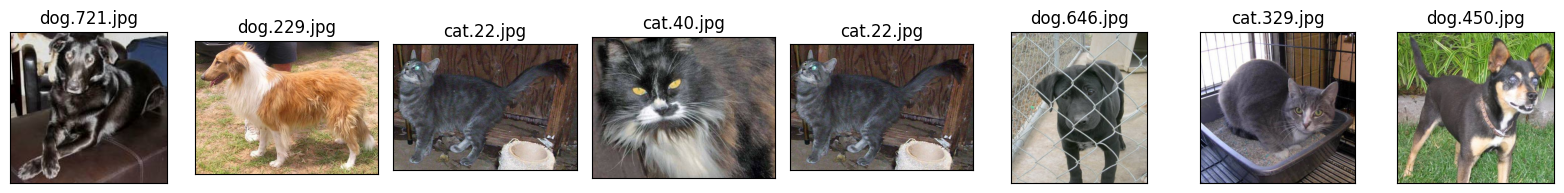

In [19]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fnames = [fn for fn in os.listdir('dogs_vs_cats_1000')]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join('dogs_vs_cats_1000', fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [20]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir('dogs_vs_cats_1000')]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join("dogs_vs_cats_1000", fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list)
            # use your embedding model to produce embeddings vectors, convert result to numpy array
            embeddings = embedding_model(x_batch.to(device)).cpu()
            assert isinstance(embeddings,  torch.Tensor)
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array.
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5


### embeddings classification with ML-1 tools

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

* Train sklearn model, evaluate validation accuracy (should be >90%)

__Task 1 (2 points)__:<br>  
- write the code for cats/dogs classification using the embeddings created above. Use any classification tools that you learned. Reach at least 95% accuracy. __(1 point)__.  Try few different tools if accuracy is not high enough. <br>
(You may choose any classifier algorithm as long as it gets above 95% accuracy. To get the max grade here, you need to tune main hyperparameters of your chosen algorithm (e.g. k for KNN, tree depth, logreg C) depending on how many data points you have. )
- try this excercise with much smaller training set. Find the lowest train set size that you can at which you can still predict cat/dog class with 95% accuracy __(1 point)__ <br>
(note: exact threshold may depend on algorightm choice and train/test split. Show your effort in  experimenting with low train set sizes.)

In [23]:
%%time
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, Y_train)

Y_pred = gb_classifier.predict(X_test)


print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

accuracy = 98.0%
CPU times: total: 1min 36s
Wall time: 1min 37s


## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

# Problem 2: Clasification of cat/dog breeds using Oxford pets dataset

The next problem is to classify specific cat / dog breeds from popular Oxford pets dataset. It is conveniently provided by Pytorch so loading and using it is very easy.

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [24]:
# Loading train and test subsets of the dataset
# using simple transform for both slices

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='trainval', target_types='category', download=True, transform=test_transform)
test_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='test', target_types='category', download=True, transform=test_transform)

print("dataset sizes:", len(train_dataset), len(test_dataset))

print(train_dataset.classes)
print(len(train_dataset.classes))

100%|██████████| 791918971/791918971 [01:59<00:00, 6619321.40it/s] 


Extracting oxford-iiit-pet\images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 8579142.68it/s] 


Extracting oxford-iiit-pet\annotations.tar.gz to oxford-iiit-pet
dataset sizes: 3680 3669
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']
37


In [49]:
# create dataloaders to repack the datasets' data into batches
# read more
from torch.utils.data import DataLoader 
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("dataloader sizes:", len(train_dataloader), len(test_dataloader))

dataloader sizes: 58 58


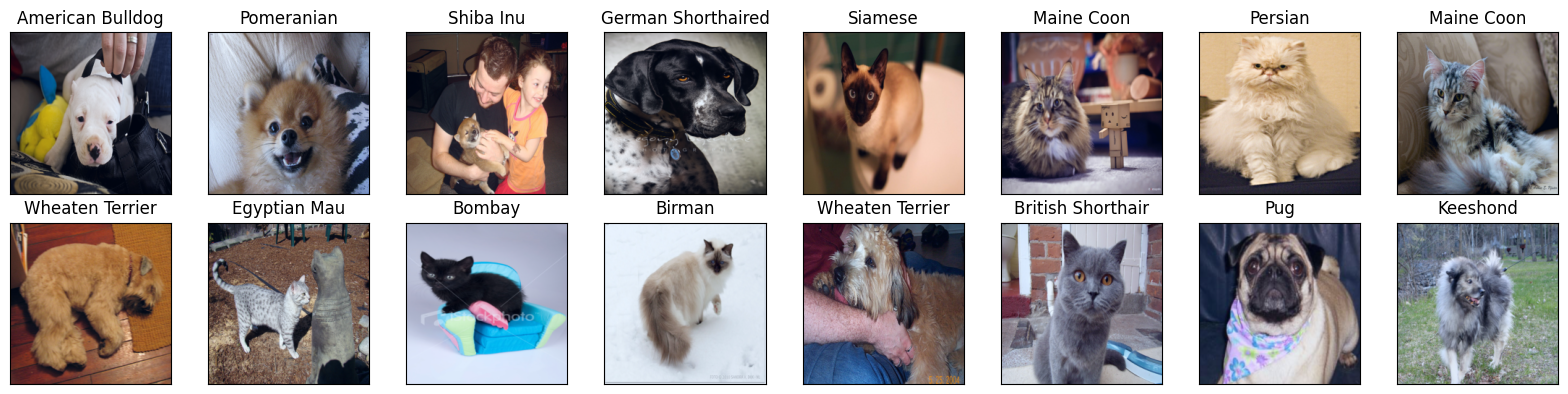

In [26]:
# Showing sample pets images
for x_batch, y_batch in train_dataloader:
    break  # Only get data from the 1st batch for now

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_ = x_batch[i].permute(1, 2, 0) # restoring dimensions order
    img_ -= img_.min().item()  # normalizing image to 0..1
    img_ /= img_.max().item()
    ax.imshow(img_)
    label = train_dataset.classes[y_batch[i]]
    ax.set_title(f"{label}")
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()

Remember that Imagenet includes quite a few cat and dog breeds among its classes.

Let's try to predcit breeds with Imagenet-pretrained model without finetuning first

In [27]:
# Predicting breeds with Imagenet-pretrained model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)  # tensor with class probabilities
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 1000]))

In [28]:
# Output top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overal, mismatch in label spaces.

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label":cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-1:][::-1]
    class_stats
    for j, l in enumerate(top_ix):
        class_stats = {f"pred_1": imagenet_labels[l],
                    f"prob_{1}": probs1.ravel()[l]}
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T.sort_values('prob_1', ascending=False)
float_cols = ['prob_1']
df.style.format('{:.2%}', subset=float_cols)

,pred_1,prob_1
Siamese,Siamese_cat,94.51%
Keeshond,keeshond,94.35%
Saint Bernard,Saint_Bernard,90.23%
Persian,Persian_cat,87.12%
Pomeranian,Pomeranian,85.34%
Pug,pug,84.19%
Samoyed,Samoyed,82.18%
Boxer,boxer,82.16%
Egyptian Mau,Egyptian_cat,82.02%
Leonberger,Leonberg,82.00%


### Finetuning CNN: classification layer only:

__Task 2: (3 points)__:<br>
Complete the code below and reach at least 85% accuracy by training only the classification layer:

In [29]:
ft_model = deepcopy(model)

# your task:
# 1) freeze all model parameters
# 2) replace model.fc with a new linear layer that has the appropriate number of outputs

for param in ft_model.parameters():
    param.requires_grad = False
ft_model.fc = torch.nn.Linear(in_features = 512,
                              out_features = 37
                        )
ft_model.fc.weight.requiers_grad = True
ft_model.fc.bias.requiers_grad = True
ft_model = ft_model.to(device)

assert all(not p.requires_grad for p in ft_model.parameters() if p not in set(ft_model.fc.parameters()))
assert ft_model.fc.out_features == len(train_dataset.classes)
#assert ft_model.fc.weight.device == device, f"ft_model.fc must be on {device}"
assert ft_model.fc.weight.requires_grad

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.001)

In [30]:
# train the finetuning model in a standard training loop.

num_epochs = 10  # Adjust number of epochs if needed

history = defaultdict(list)
for epoch in range(num_epochs):
    start_time = time.time()

    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = ft_model(x_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"

    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc

        y_pred = ft_model(x_batch.to(device))
        loss = criterion(y_pred.cpu(), y_batch)

        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=2.22428  val_loss=1.25479  accuracy=74.65%  epoch_time=99.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.91550  val_loss=0.76642  accuracy=84.08%  epoch_time=79.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.60483  val_loss=0.62132  accuracy=85.15%  epoch_time=78.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.47254  val_loss=0.54139  accuracy=86.45%  epoch_time=79.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.39242  val_loss=0.50032  accuracy=86.70%  epoch_time=82.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.34244  val_loss=0.46311  accuracy=87.41%  epoch_time=77.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.30371  val_loss=0.45597  accuracy=87.19%  epoch_time=78.8s
Best Accuracy = 87.41%


In [31]:
# This part of finetuning alone should deliver at least 85% accuracy.
assert accuracy > 0.85

In [32]:
# Predicting breeds with finetuned model

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 37]))

In [33]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    probs1 = Y_probs[class_preds].mean(axis=0).numpy()
    acc1 = probs1[i]
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

,acc1
Keeshond,92.17%
German Shorthaired,90.98%
Scottish Terrier,90.56%
Shiba Inu,89.75%
Japanese Chin,89.61%
Pomeranian,88.80%
Leonberger,88.79%
Saint Bernard,86.97%
Great Pyrenees,84.29%
English Cocker Spaniel,84.19%


### Finetuning CNN: now unfreeze and train all layers:

__task 3 (5 points)__: Based on the previous task, continue finetuning the model run by training all of its layers. Obtain at least 90% accuracy (macro average, as defined in the code).
To reach 90%, you will need to experiment with network and/or training code, start from using improvements from the list below:

Scoring:
- reaching 90% accuracy - __3 points__
- testing out all 4 of these improvements - __2 points__:
    - Hyperparameters optimization
    - Image augmentation
    - Pretrained model selection
    - Early stopping training at epoch with best metric and / or loading the weights of best epoch. [read about `state_dict`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)
    
(you may not necessarily get spectacular results right away. Experiment and describe your actions and findings in a brief report in this notebook.)
- scoring above 90% -- __+1 BONUS point__ for every 1% improvement in accuracy above 90%

__Guidelines__: to improve quality of the finetuned model we can now train all of its layers.
- do this after initial training of classification layer
- set learning rate to much lower level to avoid explosion
- make all layers trainable using `requires_grad` param

In [34]:
# Continue training with all layers involved

for param in ft_model.parameters():
    param.requires_grad = True

assert all (p.requires_grad for p in ft_model.parameters())

optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.00003)  # reduce LR to avoid explosion

In [35]:
# train the finetuning model in a standard training loop.

num_epochs = 10  # Adjust number of epochs if needed

history = defaultdict(list)
for epoch in range(num_epochs):
    start_time = time.time()

    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = ft_model(x_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"

    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc

        y_pred = ft_model(x_batch.to(device))
        loss = criterion(y_pred.cpu(), y_batch)

        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=0.24024  val_loss=0.36992  accuracy=89.53%  epoch_time=98.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.10054  val_loss=0.35902  accuracy=89.45%  epoch_time=94.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.05822  val_loss=0.34704  accuracy=89.53%  epoch_time=94.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.03830  val_loss=0.34057  accuracy=89.83%  epoch_time=93.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.02759  val_loss=0.34185  accuracy=89.89%  epoch_time=94.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.02125  val_loss=0.33527  accuracy=90.05%  epoch_time=94.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.01709  val_loss=0.33289  accuracy=89.97%  epoch_time=93.9s
Best Accuracy = 90.05%


In [36]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    probs1 = Y_probs[class_preds].mean(axis=0).numpy()
    acc1 = probs1[i]
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

,acc1
Keeshond,92.17%
German Shorthaired,90.98%
Scottish Terrier,90.56%
Shiba Inu,89.75%
Japanese Chin,89.61%
Pomeranian,88.80%
Leonberger,88.79%
Saint Bernard,86.97%
Great Pyrenees,84.29%
English Cocker Spaniel,84.19%


In [37]:
print(f"Overall Accuracy = {correct / total:.2%}")  # macro-averaged accuracy
assert correct / total >= 0.9

Overall Accuracy = 73.96%


AssertionError: 

Damn 73.96% not good at all.


Let's try play with hyperparameters:

In [48]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim

In [63]:
def objective(trial: optuna.trial.Trial):
    
    ft_model = deepcopy(model)
    ft_model.fc = torch.nn.Linear(in_features = 512,
                              out_features = 37
                            )
    
    ft_model = ft_model.to(device)
    
    optimizer_name: str = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr: float = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer:torch.optim.Optimizer = getattr(optim, optimizer_name)(ft_model.parameters(), lr=lr)
    
    # Get train and valid dataloaders
    train_loader: DataLoader = train_dataloader
    valid_loader: DataLoader = test_dataloader
    
    #Trainining of the model
    train_losses = []
    pbar = tqdm(train_loader, leave=False)
    
    history = defaultdict(list)
    for epoch in range(num_epochs):
        ft_model.train()
        for x_batch, y_batch in pbar:

            # calculate model predictions, calculate loss, make optimizer step
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = ft_model(x_batch)
            loss = criterion(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            train_losses.append(loss.item())
            pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"  
        # validation model
        ft_model.eval()
        val_losses = []
        val_cnt, val_correct = 0, 0
        
        pbar = tqdm(valid_loader, leave=False)
        with torch.inference_mode():
            for x_batch, y_batch in pbar:
                # get model predictions, measure loss, collect data for accuracy calc
                y_pred = ft_model(x_batch.to(device))
                loss = criterion(y_pred.cpu(), y_batch)
 
                val_cnt += y_batch.shape[0]
                val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
                val_losses.append(loss.item())
                
                pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        accuracy = val_correct / val_cnt
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        
        print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")
        
        trial.report(accuracy, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return accuracy
        
    

In [64]:
study: optuna.study.Study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

pruned_trials:list[optuna.trial.FrozenTrial] = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials:list[optuna.trial.FrozenTrial] = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print(" Number of finished trials:  ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials:  ", len(complete_trials))

print("Best trial:")
trial:optuna.trial.FrozenTrial = study.best_trial

print(" Value:  ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2024-01-30 19:21:09,165] A new study created in memory with name: no-name-7a1b7b53-77bd-414b-b37c-14a81292d23b


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.00134  val_loss=1.03411  accuracy=69.39%  epoch_time=80810.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.44734  val_loss=3.12764  accuracy=36.14%  epoch_time=80904.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=2.69588  val_loss=2.12171  accuracy=48.87%  epoch_time=81002.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=2.72020  val_loss=2.05474  accuracy=50.67%  epoch_time=81099.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=2.65502  val_loss=1.89096  accuracy=50.07%  epoch_time=81197.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=2.56555  val_loss=1.82776  accuracy=56.15%  epoch_time=81294.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=2.46337  val_loss=1.82869  accuracy=52.19%  epoch_time=81388.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=2.35586  val_loss=1.69838  accuracy=57.37%  epoch_time=81482.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=2.24955  val_loss=1.83655  accuracy=51.92%  epoch_time=81576.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 9: train_loss=2.14888  val_loss=1.94997  accuracy=47.34%  epoch_time=81675.6s


[I 2024-01-30 19:37:12,865] Trial 0 finished with value: 0.473426001635323 and parameters: {'optimizer': 'RMSprop', 'lr': 0.00015884456608994337}. Best is trial 0 with value: 0.473426001635323.


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=2.13816  val_loss=1.09766  accuracy=82.39%  epoch_time=81772.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.99404  val_loss=1.20019  accuracy=76.64%  epoch_time=81869.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=3.09104  val_loss=1.15173  accuracy=80.29%  epoch_time=81964.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=3.06690  val_loss=1.09141  accuracy=83.07%  epoch_time=82059.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=3.00024  val_loss=1.04304  accuracy=84.11%  epoch_time=82153.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=2.91373  val_loss=1.00574  accuracy=85.94%  epoch_time=82248.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=2.81656  val_loss=1.03852  accuracy=86.73%  epoch_time=82344.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=2.71408  val_loss=1.12837  accuracy=86.75%  epoch_time=82438.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=2.61418  val_loss=1.05440  accuracy=87.90%  epoch_time=82534.3s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 19:53:05,113] Trial 1 finished with value: 0.8612701008449168 and parameters: {'optimizer': 'Adam', 'lr': 7.637386875581485e-05}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=2.52706  val_loss=1.29863  accuracy=86.13%  epoch_time=82629.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=6.05225  val_loss=3.64274  accuracy=3.00%  epoch_time=82723.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=4.98658  val_loss=4.87174  accuracy=2.75%  epoch_time=82817.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=4.52347  val_loss=4.10669  accuracy=2.73%  epoch_time=82911.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=4.29708  val_loss=4.25114  accuracy=2.73%  epoch_time=83005.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=4.14941  val_loss=58.97577  accuracy=2.73%  epoch_time=83101.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=4.00724  val_loss=5.41342  accuracy=2.75%  epoch_time=83198.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=3.86486  val_loss=4.83194  accuracy=2.70%  epoch_time=83293.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=3.71812  val_loss=4.90803  accuracy=2.73%  epoch_time=83388.8s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=3.57223  val_loss=4.76740  accuracy=2.73%  epoch_time=83485.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 9: train_loss=3.44444  val_loss=6.34484  accuracy=2.73%  epoch_time=83581.1s


[I 2024-01-30 20:08:56,941] Trial 2 finished with value: 0.02725538293813028 and parameters: {'optimizer': 'RMSprop', 'lr': 0.010174002327362994}. Best is trial 1 with value: 0.8612701008449168.


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.12957  val_loss=0.71352  accuracy=79.72%  epoch_time=83678.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.92386  val_loss=4.12275  accuracy=3.92%  epoch_time=83773.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=3.22211  val_loss=3.60256  accuracy=5.07%  epoch_time=83867.8s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=3.36060  val_loss=3.59529  accuracy=7.50%  epoch_time=83966.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=3.44170  val_loss=3.56799  accuracy=13.85%  epoch_time=84061.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=3.49810  val_loss=3.56455  accuracy=8.67%  epoch_time=84155.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=3.53685  val_loss=3.40687  accuracy=16.41%  epoch_time=84254.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=3.55784  val_loss=3.45110  accuracy=13.95%  epoch_time=84350.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=3.56683  val_loss=3.52187  accuracy=18.92%  epoch_time=84446.2s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 20:24:56,463] Trial 3 finished with value: 0.06650313436903789 and parameters: {'optimizer': 'Adam', 'lr': 0.00036418491775657634}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=3.57749  val_loss=3.73530  accuracy=6.65%  epoch_time=84540.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.87421  val_loss=3.97327  accuracy=22.49%  epoch_time=84637.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=3.83819  val_loss=3.69655  accuracy=2.81%  epoch_time=84734.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=4.02144  val_loss=7.88666  accuracy=2.81%  epoch_time=84830.8s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=4.10522  val_loss=3.63240  accuracy=2.75%  epoch_time=84929.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=4.10779  val_loss=4.44951  accuracy=2.73%  epoch_time=85026.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=4.07605  val_loss=3.62664  accuracy=2.73%  epoch_time=85121.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=4.03982  val_loss=3.61592  accuracy=2.75%  epoch_time=85216.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=4.00674  val_loss=3.61269  accuracy=2.81%  epoch_time=85312.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=3.97742  val_loss=3.61143  accuracy=2.75%  epoch_time=85406.5s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 20:40:58,325] Trial 4 finished with value: 0.02725538293813028 and parameters: {'optimizer': 'Adam', 'lr': 0.002075350456206889}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=3.95147  val_loss=3.61046  accuracy=2.73%  epoch_time=85502.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 20:42:35,069] Trial 5 pruned. 


Ep. 0: train_loss=3.05002  val_loss=2.27046  accuracy=59.85%  epoch_time=85597.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.71391  val_loss=0.76501  accuracy=83.18%  epoch_time=85693.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=3.14253  val_loss=3.43400  accuracy=4.80%  epoch_time=85786.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=3.41420  val_loss=4.14168  accuracy=2.73%  epoch_time=85881.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=3.51321  val_loss=3.74325  accuracy=2.73%  epoch_time=85975.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=3.54933  val_loss=4.21155  accuracy=3.16%  epoch_time=86068.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=3.53883  val_loss=6.32960  accuracy=3.33%  epoch_time=86161.4s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=3.53593  val_loss=3.72477  accuracy=3.24%  epoch_time=86255.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=3.53143  val_loss=3.12492  accuracy=4.66%  epoch_time=86348.4s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=3.51216  val_loss=2.81258  accuracy=7.09%  epoch_time=86441.8s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 20:58:10,413] Trial 6 finished with value: 0.09103297901335514 and parameters: {'optimizer': 'SGD', 'lr': 0.031147851678642972}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=3.48738  val_loss=2.81059  accuracy=9.10%  epoch_time=86534.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 20:59:43,293] Trial 7 pruned. 


Ep. 0: train_loss=2.22594  val_loss=4.92619  accuracy=15.89%  epoch_time=86627.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.14833  val_loss=0.67327  accuracy=80.76%  epoch_time=86721.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.90201  val_loss=3.96838  accuracy=2.64%  epoch_time=86815.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=3.20199  val_loss=3.63696  accuracy=2.62%  epoch_time=86910.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=3.34953  val_loss=4.11534  accuracy=3.16%  epoch_time=87003.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=3.44814  val_loss=3.64472  accuracy=2.73%  epoch_time=87097.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=3.50713  val_loss=3.60399  accuracy=3.54%  epoch_time=87193.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=3.54619  val_loss=3.62122  accuracy=5.59%  epoch_time=87287.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=3.57814  val_loss=3.78906  accuracy=6.32%  epoch_time=87381.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=3.60339  val_loss=3.56871  accuracy=7.09%  epoch_time=87476.1s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 21:15:26,401] Trial 8 finished with value: 0.09457617879531208 and parameters: {'optimizer': 'Adam', 'lr': 0.00037189689915225464}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=3.62394  val_loss=3.55513  accuracy=9.46%  epoch_time=87570.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 21:46:59,682] Trial 9 pruned. 


Ep. 0: train_loss=3.84344  val_loss=3.84736  accuracy=1.74%  epoch_time=89463.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 21:48:33,583] Trial 10 pruned. 


Ep. 0: train_loss=3.33280  val_loss=2.72351  accuracy=35.98%  epoch_time=89557.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 21:50:06,308] Trial 11 pruned. 


Ep. 0: train_loss=1.02493  val_loss=0.92282  accuracy=74.57%  epoch_time=89650.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.19777  val_loss=0.72568  accuracy=83.59%  epoch_time=89743.8s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.44243  val_loss=2.22773  accuracy=72.83%  epoch_time=89837.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=2.66285  val_loss=1.85224  accuracy=73.54%  epoch_time=89930.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=2.70046  val_loss=1.68885  accuracy=73.29%  epoch_time=90024.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=2.67457  val_loss=1.55636  accuracy=72.50%  epoch_time=90117.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=2.62307  val_loss=1.82113  accuracy=70.13%  epoch_time=90211.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=2.57429  val_loss=1.12744  accuracy=77.02%  epoch_time=90304.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=2.51517  val_loss=1.08592  accuracy=78.28%  epoch_time=90398.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=2.44756  val_loss=1.11188  accuracy=77.73%  epoch_time=90492.5s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 22:05:42,315] Trial 12 finished with value: 0.7467974925047697 and parameters: {'optimizer': 'RMSprop', 'lr': 6.525178855405432e-05}. Best is trial 1 with value: 0.8612701008449168.


Ep. 9: train_loss=2.37700  val_loss=1.26641  accuracy=74.68%  epoch_time=90586.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.32663  val_loss=0.80102  accuracy=82.31%  epoch_time=90680.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.53663  val_loss=0.82487  accuracy=84.06%  epoch_time=90774.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=2.73647  val_loss=0.79611  accuracy=84.90%  epoch_time=90868.0s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=2.76379  val_loss=0.76589  accuracy=86.24%  epoch_time=90962.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=2.72983  val_loss=0.80323  accuracy=86.81%  epoch_time=91057.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=2.66802  val_loss=0.82958  accuracy=88.17%  epoch_time=91152.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=2.59204  val_loss=0.86115  accuracy=88.12%  epoch_time=91245.4s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=2.50932  val_loss=0.96862  accuracy=89.13%  epoch_time=93260.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=2.42521  val_loss=1.07919  accuracy=89.34%  epoch_time=93352.2s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 22:53:20,996] Trial 13 finished with value: 0.8958844371763424 and parameters: {'optimizer': 'RMSprop', 'lr': 5.70366511085558e-05}. Best is trial 13 with value: 0.8958844371763424.


Ep. 9: train_loss=2.34549  val_loss=0.99318  accuracy=89.59%  epoch_time=93445.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 22:55:15,602] Trial 14 pruned. 


Ep. 0: train_loss=2.87952  val_loss=2.25285  accuracy=58.24%  epoch_time=93559.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 22:56:50,531] Trial 15 pruned. 


Ep. 0: train_loss=2.61086  val_loss=1.49065  accuracy=76.15%  epoch_time=93654.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 22:58:27,621] Trial 16 pruned. 


Ep. 0: train_loss=1.96281  val_loss=2.22834  accuracy=43.77%  epoch_time=93751.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.53974  val_loss=0.73510  accuracy=83.62%  epoch_time=93845.8s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=2.89271  val_loss=2.04932  accuracy=46.99%  epoch_time=93939.9s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=3.10719  val_loss=1.37758  accuracy=61.65%  epoch_time=94034.5s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=3.13232  val_loss=1.37413  accuracy=66.64%  epoch_time=94129.6s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=3.07258  val_loss=1.95300  accuracy=60.67%  epoch_time=94224.1s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=2.97882  val_loss=1.82971  accuracy=64.00%  epoch_time=94318.7s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=2.88415  val_loss=1.66284  accuracy=62.61%  epoch_time=94414.3s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=2.79835  val_loss=1.81823  accuracy=65.58%  epoch_time=94509.2s


  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=2.70661  val_loss=1.51710  accuracy=73.37%  epoch_time=94604.1s


  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 23:14:20,127] Trial 17 finished with value: 0.8623603161624421 and parameters: {'optimizer': 'Adam', 'lr': 0.00015946498993496018}. Best is trial 13 with value: 0.8958844371763424.


Ep. 9: train_loss=2.60172  val_loss=1.37275  accuracy=86.24%  epoch_time=94704.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 23:15:53,852] Trial 18 pruned. 


Ep. 0: train_loss=3.87755  val_loss=3.65652  accuracy=4.33%  epoch_time=94798.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-01-30 23:17:27,564] Trial 19 pruned. 


Ep. 0: train_loss=3.81968  val_loss=3.78930  accuracy=1.72%  epoch_time=94891.7s
Study statistics: 
 Number of finished trials:   20
 Number of pruned trials:  10
 Number of complete trials:   10
Best trial:
 Value:   0.8958844371763424
 Params: 
 optimizer: RMSprop
 lr: 5.70366511085558e-05


Let's create our new optim:

In [72]:
ft_model = deepcopy(model)
ft_model.fc = torch.nn.Linear(in_features = 512,
                              out_features = 37
                            )
    
ft_model = ft_model.to(device)
optimizer = torch.optim.RMSprop(ft_model.parameters(), lr=study.best_params['lr'])
    

In [73]:
# train the finetuning model in a standard training loop.

num_epochs = 10  # Adjust number of epochs if needed

history = defaultdict(list)
for epoch in range(num_epochs):
    start_time = time.time()

    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = ft_model(x_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"

    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc

        y_pred = ft_model(x_batch.to(device))
        loss = criterion(y_pred.cpu(), y_batch)

        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.25760  val_loss=0.73086  accuracy=85.36%  epoch_time=177.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.33783  val_loss=0.59371  accuracy=86.13%  epoch_time=94.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.15079  val_loss=0.50015  accuracy=87.60%  epoch_time=95.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.07798  val_loss=0.47078  accuracy=88.17%  epoch_time=96.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.04106  val_loss=0.46078  accuracy=87.82%  epoch_time=97.8s
Best Accuracy = 88.17%


In [74]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    probs1 = Y_probs[class_preds].mean(axis=0).numpy()
    acc1 = probs1[i]
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

,acc1
Keeshond,92.17%
German Shorthaired,90.98%
Scottish Terrier,90.56%
Shiba Inu,89.75%
Japanese Chin,89.61%
Pomeranian,88.80%
Leonberger,88.79%
Saint Bernard,86.97%
Great Pyrenees,84.29%
English Cocker Spaniel,84.19%


In [75]:
print(f"Overall Accuracy = {correct / total:.2%}")  # macro-averaged accuracy
assert correct / total >= 0.9


Overall Accuracy = 73.96%


AssertionError: 

# STUDENT'S REPORT

Please write a short report describing the steps you took to improve quality. It should be at least a short paragraph with 3-5 sentences and, optionally, any relevant numbers/charts, but there's no upper limit.

Here's what i did: <YOUR TEXT>

# Bonus task __(optional. 2 more points)__:

Notice that accuracy varies across breeds. Build confusion Propose improvements to the model finetuning process to improve minimal accuracy levels for all classes. Show the model runs.
Measure the improvement in terms of minimal accuracy and micro-averaged accuracy.

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet